In [1]:
from deep_traffic_generation.tcvae import TCVAE
from deep_traffic_generation.VAE_Generation import SingleStageVAE
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDataset
from traffic.core import Traffic

from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from os import walk

In [24]:
dataset = TrafficDataset.from_file(
    "../deep_traffic_generation/data/training_datasets/ga_LSZH_14_100.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

In [26]:
path = "../deep_traffic_generation/lightning_logs/tcvae/version_5/"

t = SingleStageVAE(X = dataset, sim_type = "generation")
t.load(path, dataset.parameters)
g = Generation(generation=t, features = t.VAE.hparams.features, scaler=dataset.scaler)

In [4]:
traffic = Traffic.from_file("../deep_traffic_generation/data/training_datasets/ga_LSZH_14.pkl")
latlon = traffic.data.groupby(by="flight_id")["latitude", "longitude"].first()
print(latlon.latitude.mean(), latlon.longitude.mean())

47.500085790354625 8.5114919243637


/tmp/ipykernel_24747/2149178506.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  latlon = traffic.data.groupby(by="flight_id")["latitude", "longitude"].first()


findfont: Font family 'Fira Sans' not found.
findfont: Font family 'Fira Sans' not found.
findfont: Font family 'Fira Sans' not found.
findfont: Font family 'Fira Sans' not found.
findfont: Font family 'Fira Sans' not found.


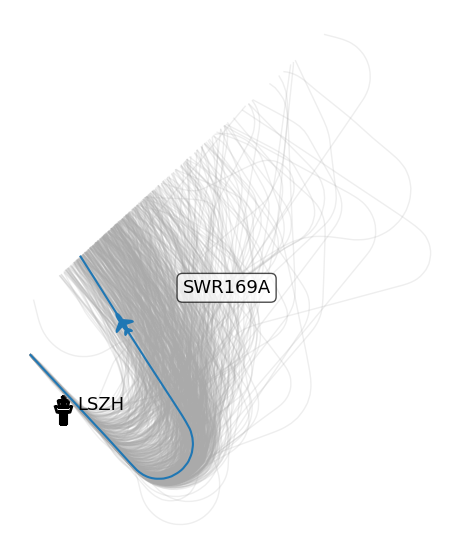

In [6]:
from traffic.core import Traffic
import matplotlib.pyplot as plt
from traffic.core.projection import EuroPP
from traffic.data import navaids
from traffic.data import airports


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7), subplot_kw=dict(projection=EuroPP()))
    ax.figure

    traffic.plot(ax, alpha=0.2)

    k =  np.random.randint(len(traffic))
    traffic[k].plot(ax, color="#1f77b4", lw=1.5)
    traffic[k].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].point.plot(ax)

    plt.show()

# Latent Space

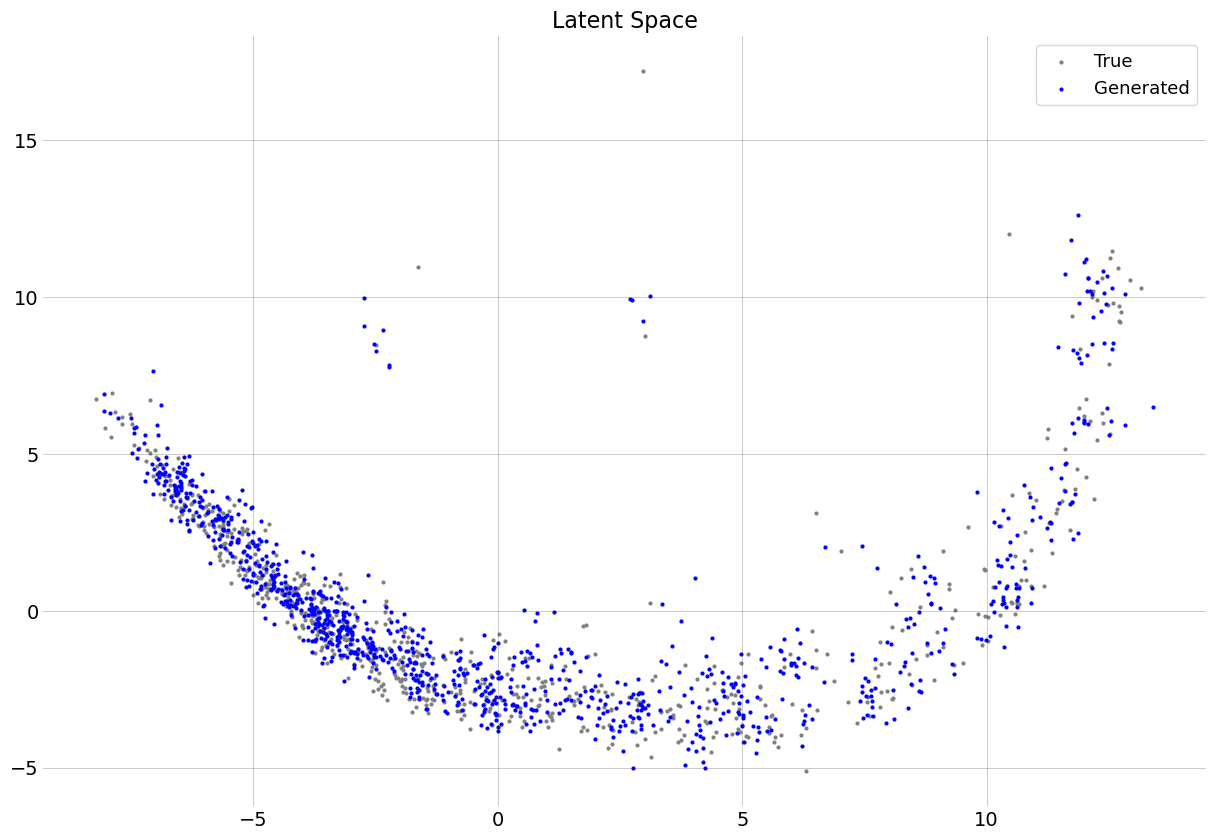

In [27]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

n_gen = 1000
Z = t.latent_space(n_gen)

#Only fitted on train data
pca = PCA(n_components=2).fit(Z[:-n_gen])
Z_embedded = pca.transform(Z)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, figsize=(15, 10))

    ax.scatter(Z_embedded[:-n_gen, 0], Z_embedded[:-n_gen, 1], s=4, c ='grey', label = "True")
    ax.scatter(Z_embedded[-n_gen:, 0], Z_embedded[-n_gen:, 1], s=4, c='blue', label = "Generated")
    ax.title.set_text("Latent Space")
    ax.legend()

    plt.show()

# Reconstruction

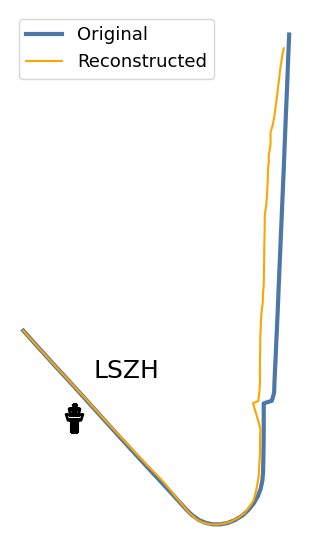

In [35]:
# VAE builds track unwrapped: need to build track column from it. 
# Then reconstruct the trajectory from the constructed track column

from traffic.core.projection import EuroPP
from traffic.data import airports
from traffic.drawing import countries
import matplotlib.pyplot as plt

j = np.random.randint(len(dataset))

original = dataset.data[j].unsqueeze(0)
original = original.transpose(1,2).reshape((original.shape[0], -1))
original = dataset.scaler.inverse_transform(original)
original_traf = g.build_traffic(original, coordinates = dict(latitude = 47.50008, longitude = 8.51149), forward=True)

h = t.VAE.encoder(dataset.data[j].unsqueeze(0))
z = t.VAE.lsr(h).rsample()
reconstructed = t.decode(z)
reconstructed_traf = g.build_traffic(reconstructed, coordinates = dict(latitude = 47.50008, longitude = 8.51149), forward=True)


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, subplot_kw=dict(projection=EuroPP()))
    original_traf.plot(ax, c="#4c78a8", lw = 3, label = "Original")
    reconstructed_traf.plot(ax, c="orange", label = "Reconstructed")
    plt.legend()

    airports["LSZH"].point.plot(ax, shift=dict(units="dots", x=20, y=40), text_kw= {"fontsize" : 18})

    plt.show()

# original_traf[0] | reconstructed_traf[0]


# Generation

In [36]:
#Computing the pseudo inputs

#Vampprior
pseudo_X = t.VAE.lsr.pseudo_inputs_NN(t.VAE.lsr.idle_input) 
pseudo_X = pseudo_X.view((pseudo_X.shape[0], 4, 100))

pseudo_h = t.VAE.encoder(pseudo_X)
pseudo_means = t.VAE.lsr.z_loc(pseudo_h)
pseudo_scales = (t.VAE.lsr.z_log_var(pseudo_h) / 2).exp()

/tmp/ipykernel_24747/1079823280.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(points, ax=ax0)


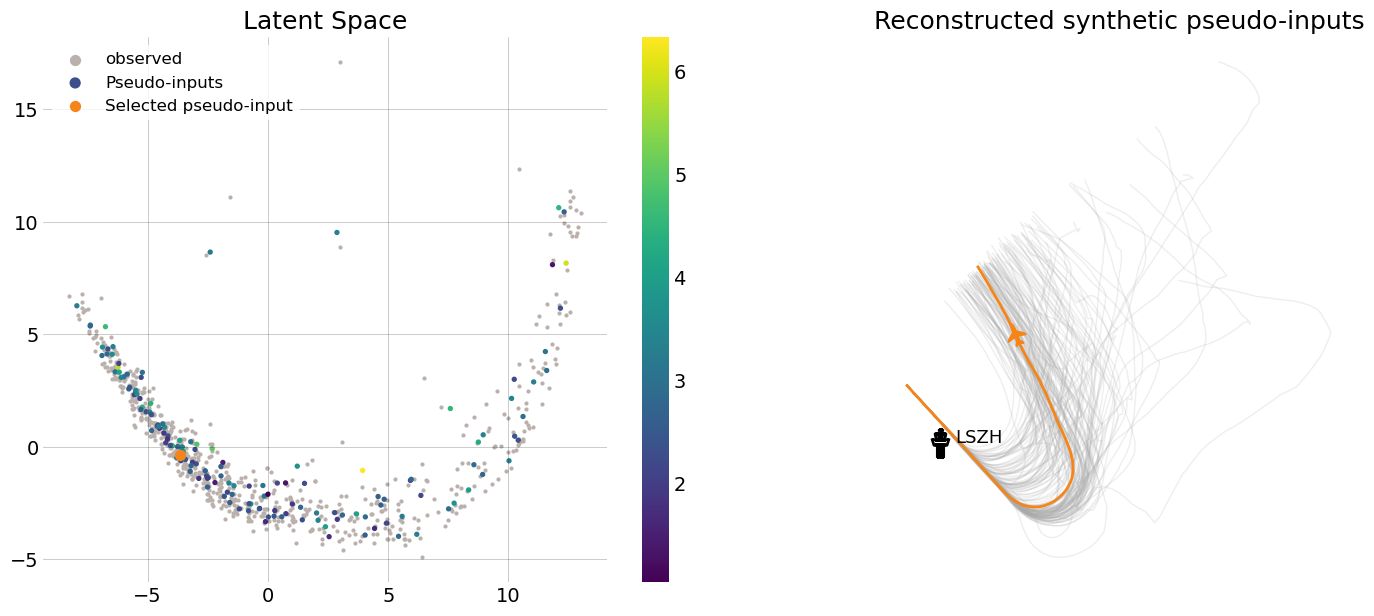

In [37]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from traffic.core.projection import EuroPP
from traffic.data import airports
from traffic.drawing import countries
from scipy.signal import savgol_filter

#Reconstructed pseudo-inputs
out = t.decode(pseudo_means)
out[:,3] = 0
out_traf = g.build_traffic(out,coordinates = dict(latitude = 47.50008, longitude = 8.51149), forward=True)

#latent spaces from train dataset and pseudo_inputs
z_train = t.latent_space(1)

out_obs = t.decode(torch.Tensor(z_train))
out_obs[:,3] = 0
out_obs_traf = g.build_traffic(out_obs,coordinates = dict(latitude = 47.50008, longitude = 8.51149), forward=True)


Z = np.concatenate((z_train, pseudo_means.detach().numpy()), axis=0)
pca = PCA(n_components=2).fit(Z[:-len(pseudo_means)])
Z_embedded = pca.transform(Z)

#col depending on the scales
col = torch.norm(pseudo_scales, dim = 1, p = 2).detach().numpy()

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(15, 12))
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222, projection=EuroPP())

    k = np.random.randint(150)


    ax0.scatter(
        Z_embedded[:-len(pseudo_means), 0], Z_embedded[:-len(pseudo_means), 1], c="#bab0ac", s=4, label="observed"
    )
    points = ax0.scatter(
        Z_embedded[-len(pseudo_means):, 0],
        Z_embedded[-len(pseudo_means):, 1],
        s=8,
        c=col,
        cmap="viridis",
        label="Pseudo-inputs",
    )
    ax0.scatter(
        Z_embedded[z_train.shape[0]+k, 0],
        Z_embedded[z_train.shape[0]+k, 1],
        s=50,
        marker="o",
        c="#f58518",
        label="Selected pseudo-input",
    )
    ax0.set_title("Latent Space", fontsize=18)

    legend = ax0.legend(loc="upper left", fontsize=12)
    legend.get_frame().set_edgecolor("none")
    legend.legendHandles[0]._sizes = [50]
    legend.legendHandles[1]._sizes = [50]
    legend.legendHandles[2]._sizes = [50]

    fig.colorbar(points, ax=ax0)

    ax1.set_title("Reconstructed synthetic pseudo-inputs", fontsize=18)
    out_traf.plot(ax1, alpha=0.2)
    out_traf["TRAJ_" + str(k)].plot(ax1, color="#f58518", lw=2)
    out_traf["TRAJ_" + str(k)].at_ratio(0.85).plot(
        ax1,
        color="#f58518",
        zorder=5,
        text_kw={"s": None},
    )

    airports["LSZH"].point.plot(ax1)
    fig.tight_layout()
    plt.show()

In [16]:
#Find a way to link flight_ids from observed trajectories -> impossible, information lost within Trafficdataset -> Peut-être possible de le link avec le traffic downloaded. TrafficDataset same order as traffic object ?
#Or find a way to display reconstructed trajectories next to it
# decode pseudo means AND decode z_train. Order within decodings is the same as order within dataframe (TRAJ_0, TRAJ_1,....)

import pandas as pd

Z_embedded = pd.DataFrame(Z_embedded, columns=["X1", "X2"])

Z_embedded["var"] = np.nan
Z_embedded.loc[(len(Z_embedded)-len(pseudo_means)):, "var"] = col

Z_embedded["type"] = np.nan
Z_embedded.loc[:(len(Z_embedded)-len(pseudo_means)), "type"] = "obs"
Z_embedded.loc[(len(Z_embedded)-len(pseudo_means)):, "type"] = "pi"


In [38]:
np.argsort(col)

array([ 60, 112,  55,  11,  84, 109,  20,  95, 110,   4,  70,  68,  90,
        37,  18, 135,  21, 142,  91,  17,  39, 145,  58,   7, 121, 119,
       100,  50,  38,  12,  73, 127,  79, 116, 124,  97,  61,  94,  93,
         0,  88,  32,  14, 106, 136,   5,  80,  89, 143,   6, 105,  59,
         8, 108,  52, 120, 146,  42,  51,  10, 122,  47,  30,  82, 126,
        13,  36, 113, 132,  63,  72, 117,  44,  99,  54, 103, 115,  92,
       128,  40,  98,  96,  67,   1, 123, 125,  26,  16,  15,  27,  87,
        22,  53, 114,  74,  34,  46,  86,  85,  64, 104,  31, 118,   3,
       140,  62,  41, 141,  23,  65,  57,  81,  29, 102,  49,  77,   9,
       129,  19, 111, 148, 149,  75, 133,  33,  69,  71,  76,  45, 147,
       101,  28, 130, 144, 138,  35,  56,  78, 137,  43, 134,  48, 107,
         2,  24, 139,  83,  25, 131,  66])

Version 2:
- Variances lower than pseudo input 46 are good

Maybe try the method from Julien: 
- First, do a pre-training without the KL divergence. We want to train simultaneously VampPrior, but how is it possible if there is no KL ? (ask him)
- Then, train the VAE based on the pre-training. 

In [191]:
import pandas as pd

# js = np.random.randint(0,150,2)
js = [60,55]
n_gen = 100

dist1 = torch.distributions.Independent(
    torch.distributions.Normal(pseudo_means[js[0]], pseudo_scales[js[0]]), 1
)
gen1 = dist1.sample(torch.Size([n_gen]))

dist2 = torch.distributions.Independent(
    torch.distributions.Normal(pseudo_means[js[1]], pseudo_scales[js[1]]), 1
)
gen2 = dist2.sample(torch.Size([n_gen]))

decode1 = t.decode(
    torch.cat((pseudo_means[js[0]].unsqueeze(0), gen1), axis=0)
)
decode2 = t.decode(
    torch.cat((pseudo_means[js[1]].unsqueeze(0), gen2), axis=0)
)

# Neural net don't predict exaclty timedelta = 0 for the first observation
decode1[:, 3] = 0
decode2[:, 3] = 0

traf_gen1 = g.build_traffic(
    decode1,
    coordinates = dict(latitude = 47.50008, longitude = 8.51149), 
    forward=True
)
traf_gen1 = traf_gen1.assign(gen_number=lambda x: 1)

traf_gen2 = g.build_traffic(
    decode2,
    coordinates = dict(latitude = 47.50008, longitude = 8.51149), 
    forward=True
)
traf_gen2 = traf_gen2.assign(gen_number=lambda x: 2)

z_train = t.latent_space(1)
gen = torch.cat((gen1, gen2, pseudo_means[js]), axis=0)
concat = np.concatenate((z_train, gen.detach().numpy()))
pca = PCA(n_components=2).fit(concat[: -len(gen)])
gen_embedded = pca.transform(concat)

gen_embedded = pd.DataFrame(gen_embedded, columns=["X1", "X2"])
gen_embedded["type"] = np.nan
gen_embedded.type[-(2 * n_gen + 2) :] = "GEN1"
gen_embedded.type[-(n_gen + 2) :] = "GEN2"
gen_embedded.type[-2:] = "PI1"
gen_embedded.type[-1:] = "PI2"

/tmp/ipykernel_24747/3911478025.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen_embedded.type[-(2 * n_gen + 2) :] = "GEN1"


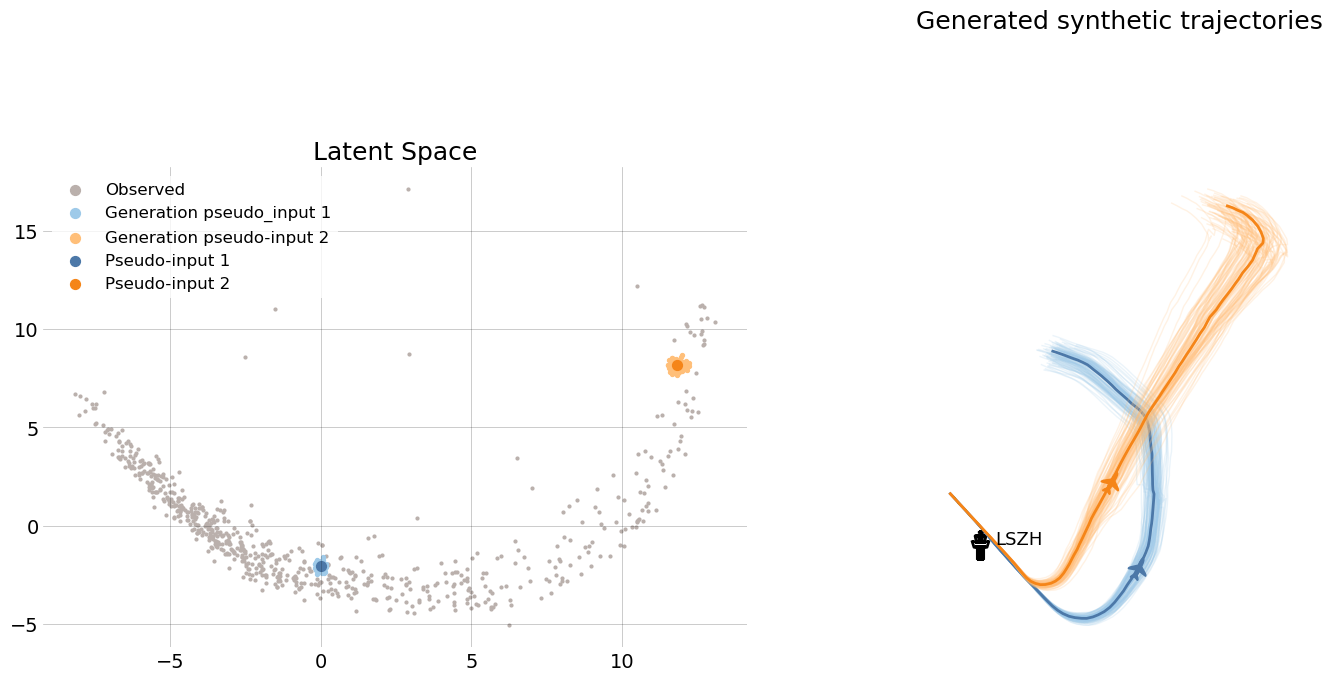

In [192]:
with plt.style.context("traffic"):
    fig = plt.figure(figsize=(15, 12))
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222, projection=EuroPP())

    ax0.scatter(
        gen_embedded.query("type.isnull()").X1,
        gen_embedded.query("type.isnull()").X2,
        c="#bab0ac",
        s=4,
        label="Observed",
    )
    ax0.scatter(
        gen_embedded.query("type == 'GEN1'").X1,
        gen_embedded.query("type == 'GEN1'").X2,
        c="#9ecae9",
        s=8,
        label="Generation pseudo_input 1",
    )
    ax0.scatter(
        gen_embedded.query("type == 'GEN2'").X1,
        gen_embedded.query("type == 'GEN2'").X2,
        c="#ffbf79",
        s=8,
        label="Generation pseudo-input 2",
    )
    ax0.scatter(
        gen_embedded.query("type == 'PI1'").X1,
        gen_embedded.query("type == 'PI1'").X2,
        c="#4c78a8",
        s=50,
        label="Pseudo-input 1",
    )
    ax0.scatter(
        gen_embedded.query("type == 'PI2'").X1,
        gen_embedded.query("type == 'PI2'").X2,
        c="#f58518",
        s=50,
        label="Pseudo-input 2",
    )
    ax0.set_title("Latent Space", fontsize=18)

    legend = ax0.legend(loc="upper left", fontsize=12)
    legend.get_frame().set_edgecolor("none")
    legend.legendHandles[0]._sizes = [50]
    legend.legendHandles[1]._sizes = [50]
    legend.legendHandles[2]._sizes = [50]

    ax1.set_title("Generated synthetic trajectories", pad=100, fontsize=18)

    traf_gen1.plot(ax1, alpha=0.2, color="#9ecae9")
    traf_gen1["TRAJ_0"].plot(ax1, color="#4c78a8", lw=2)
    traf_gen1["TRAJ_0"].at_ratio(0.5).plot(
        ax1,
        color="#4c78a8",
        zorder=5,
        text_kw={"s": None},
    )

    traf_gen2.plot(ax1, alpha=0.2, color="#ffbf79")
    traf_gen2["TRAJ_0"].plot(ax1, color="#f58518", lw=2)
    traf_gen2["TRAJ_0"].at_ratio(0.5).plot(
        ax1,
        color="#f58518",
        zorder=5,
        text_kw={"s": None},
    )

    airports["LSZH"].point.plot(ax1)
    fig.tight_layout()

    plt.show()